In [54]:
import configparser
import psycopg2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix,auc,accuracy_score,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [85]:
config = configparser.ConfigParser()
config.read('C:\Files and Folders\project\dwh.cfg')

['C:\\Files and Folders\\project\\dwh.cfg']

In [90]:
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

In [91]:
query = 'SELECT * FROM trainingChurn'
df = pd.read_sql(query, conn)
cur.close()
conn.close()
df.head()

user_id  nb_visits  nb_purchase  amount_purchase  nb_products_seen  \
0    42684          6            1             15.0                 6   
1   141703         31            0              0.0                29   
2    99207        127            1             12.0                37   
3   125565        126            0              0.0                76   
4    45503        575            7            258.0               379   

   nb__distinct_products  nb_distinct_category0  nb_distinct_category1  \
0                      4                      3                      4   
1                     28                      7                     21   
2                     37                      7                     19   
3                     69                     10                     34   
4                    313                     11                     71   

   nb_distinct_category2  nb_distinct_product_purchased  ...  \
0                      4                              1  ...   
1                     21                              0  ...   
2                     19                              1  ...   
3                     34                              0  ...   
4                     71                              7  ...   

   nb_associated_months  nb_days_last_activity  nb_days_last_purchase  \
0                     1                     59                     68   
1                     6                     32                  99999   
2                     2                     32                     95   
3                     2                     32                  99999   
4                     8                     32                     34   

   nb_active_months  nb_active_purchase_months  nb_purchase_total  \
0                 2                          1                  1   
1                 5                          0                  0   
2                 3                          1                  1   
3                 3                          0                  0   
4                 9                          2                  7   

   amount_purchase_total  visit_current_month  current_month_purchase  \
0                   15.0                    1                       0   
1                    0.0                    1                       1   
2                   12.0                    1                       0   
3                    0.0                    1                       1   
4                  258.0                    1                       4   

   purchase_current_month  
0                       0  
1                       1  
2                       0  
3                       1  
4                       1  

[5 rows x 31 columns]

In [55]:
df = pd.read_csv(r'final_dataset.csv').sample(frac=1, random_state=42)
df.head()

user_id  nb_visits  nb_purchase  amount_purchase  nb_products_seen  \
853      54365         44            0              0.0                32   
18842    82927          5            0              0.0                 5   
28988    59375          1            0              0.0                 1   
28025      352          1            0              0.0                 1   
3585     36361         10            0              0.0                10   

       nb__distinct_products  nb_distinct_category0  nb_distinct_category1  \
853                       30                      6                     17   
18842                      5                      4                      4   
28988                      1                      1                      1   
28025                      1                      1                      1   
3585                      10                      5                      9   

       nb_distinct_category2  nb_distinct_product_purchased  ...  \
853                       17                              0  ...   
18842                      4                              0  ...   
28988                      1                              0  ...   
28025                      1                              0  ...   
3585                       9                              0  ...   

       nb_associated_months  nb_days_last_activity  nb_days_last_purchase  \
853                       2                     32                  99999   
18842                     1                    113                  99999   
28988                     0                     95                  99999   
28025                     0                     51                  99999   
3585                      0                     63                  99999   

       nb_active_months  nb_active_purchase_months  nb_purchase_total  \
853                   3                          0                  0   
18842                 2                          0                  0   
28988                 1                          0                  0   
28025                 1                          0                  0   
3585                  1                          0                  0   

       amount_purchase_total  visit_current_month  current_month_purchase  \
853                      0.0                    1                       0   
18842                    0.0                    0                       0   
28988                    0.0                    0                       0   
28025                    0.0                    0                       0   
3585                     0.0                    0                       0   

       purchase_current_month  
853                         0  
18842                       0  
28988                       0  
28025                       0  
3585                        0  

[5 rows x 31 columns]

In [56]:
df.describe()

user_id     nb_visits   nb_purchase  amount_purchase  \
count   37752.000000  37752.000000  37752.000000     3.775200e+04   
mean    75943.514013     11.584260      0.457459     2.219497e+03   
std     43820.881823     48.768833      1.770146     2.991416e+05   
min         1.000000      1.000000      0.000000     0.000000e+00   
25%     37707.500000      1.000000      0.000000     0.000000e+00   
50%     76152.500000      3.000000      0.000000     0.000000e+00   
75%    113905.250000      8.000000      1.000000     0.000000e+00   
max    151850.000000   4218.000000    108.000000     4.109312e+07   

       nb_products_seen  nb__distinct_products  nb_distinct_category0  \
count      37752.000000           37752.000000           37752.000000   
mean           8.162561               7.501854               2.545878   
std           39.301603              28.671651               2.396370   
min            0.000000               0.000000               0.000000   
25%            1.000000               1.000000               1.000000   
50%            2.000000               2.000000               2.000000   
75%            6.000000               5.000000               3.000000   
max         3967.000000            2068.000000              11.000000   

       nb_distinct_category1  nb_distinct_category2  \
count           37752.000000           37752.000000   
mean                4.513801               4.521111   
std                 7.384244               7.413544   
min                 0.000000               0.000000   
25%                 1.000000               1.000000   
50%                 2.000000               2.000000   
75%                 5.000000               5.000000   
max                99.000000             102.000000   

       nb_distinct_product_purchased  ...  nb_associated_months  \
count                   37752.000000  ...          37752.000000   
mean                        0.455446  ...              2.539097   
std                         1.763921  ...              3.070634   
min                         0.000000  ...              0.000000   
25%                         0.000000  ...              0.000000   
50%                         0.000000  ...              1.000000   
75%                         1.000000  ...              6.000000   
max                       107.000000  ...              8.000000   

       nb_days_last_activity  nb_days_last_purchase  nb_active_months  \
count           37752.000000           37752.000000      37752.000000   
mean               67.408243           67671.122192          2.811056   
std                28.954400           46737.847294          2.458003   
min                32.000000              32.000000          1.000000   
25%                41.000000             122.000000          1.000000   
50%                60.000000           99999.000000          2.000000   
75%                92.000000           99999.000000          4.000000   
max               123.000000           99999.000000          9.000000   

       nb_active_purchase_months  nb_purchase_total  amount_purchase_total  \
count               37752.000000       37752.000000           3.775200e+04   
mean                    0.457724           0.809758           2.502243e+03   
std                     0.877531           3.294414           3.029746e+05   
min                     0.000000           0.000000           0.000000e+00   
25%                     0.000000           0.000000           0.000000e+00   
50%                     0.000000           0.000000           0.000000e+00   
75%                     1.000000           1.000000           1.000000e+01   
max                     9.000000         223.000000           4.109314e+07   

       visit_current_month  current_month_purchase  purchase_current_month  
count         37752.000000            37752.000000            37752.000000  
mean              0.328751                0.090697                0.046408  
std               0.469765               

In [57]:
df.isnull().sum()

user_id                                      0
nb_visits                                    0
nb_purchase                                  0
amount_purchase                              0
nb_products_seen                             0
nb__distinct_products                        0
nb_distinct_category0                        0
nb_distinct_category1                        0
nb_distinct_category2                        0
nb_distinct_product_purchased                0
nb_distinct_category_purchased               0
nb_visits_last_month                         0
nb_purchase_last_month                       0
amount_purchase_last_month                   0
nb_products_seen_last_month                  0
nb__distinct_products_last_month             0
nb_distinct_category0_last_month             0
nb_distinct_category1_last_month             0
nb_distinct_category2_last_month             0
nb_distinct_product_purchased_last_month     0
nb_distinct_category_purchased_last_month    0
nb_associated

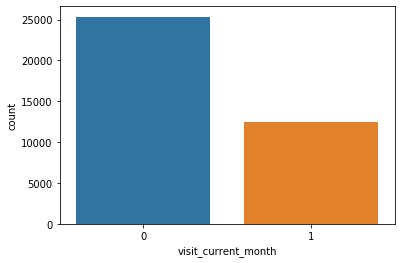

In [26]:
sns.countplot(x='visit_current_month', data=df)

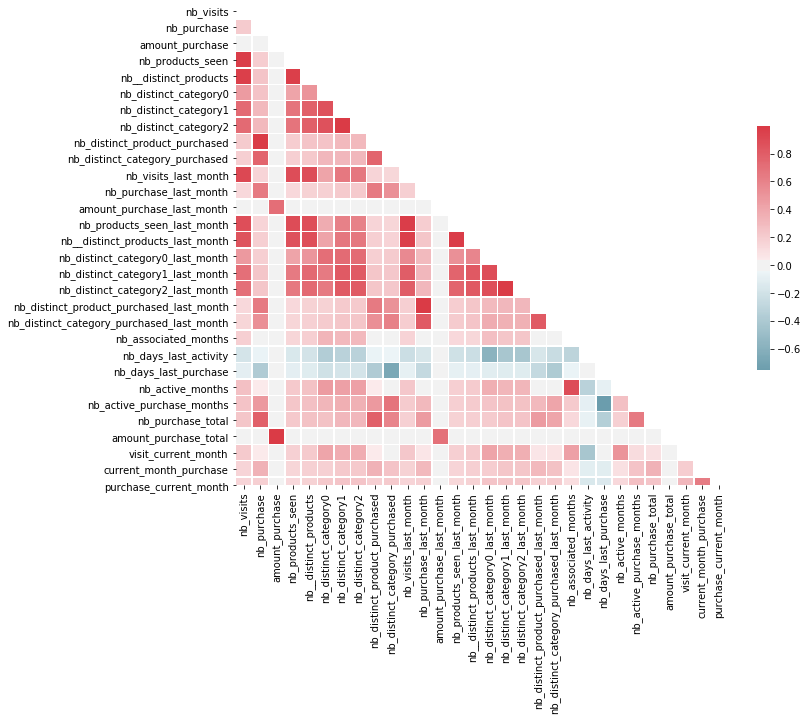

In [5]:
corr = df.loc[:, df.columns != 'user_id'].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#corr

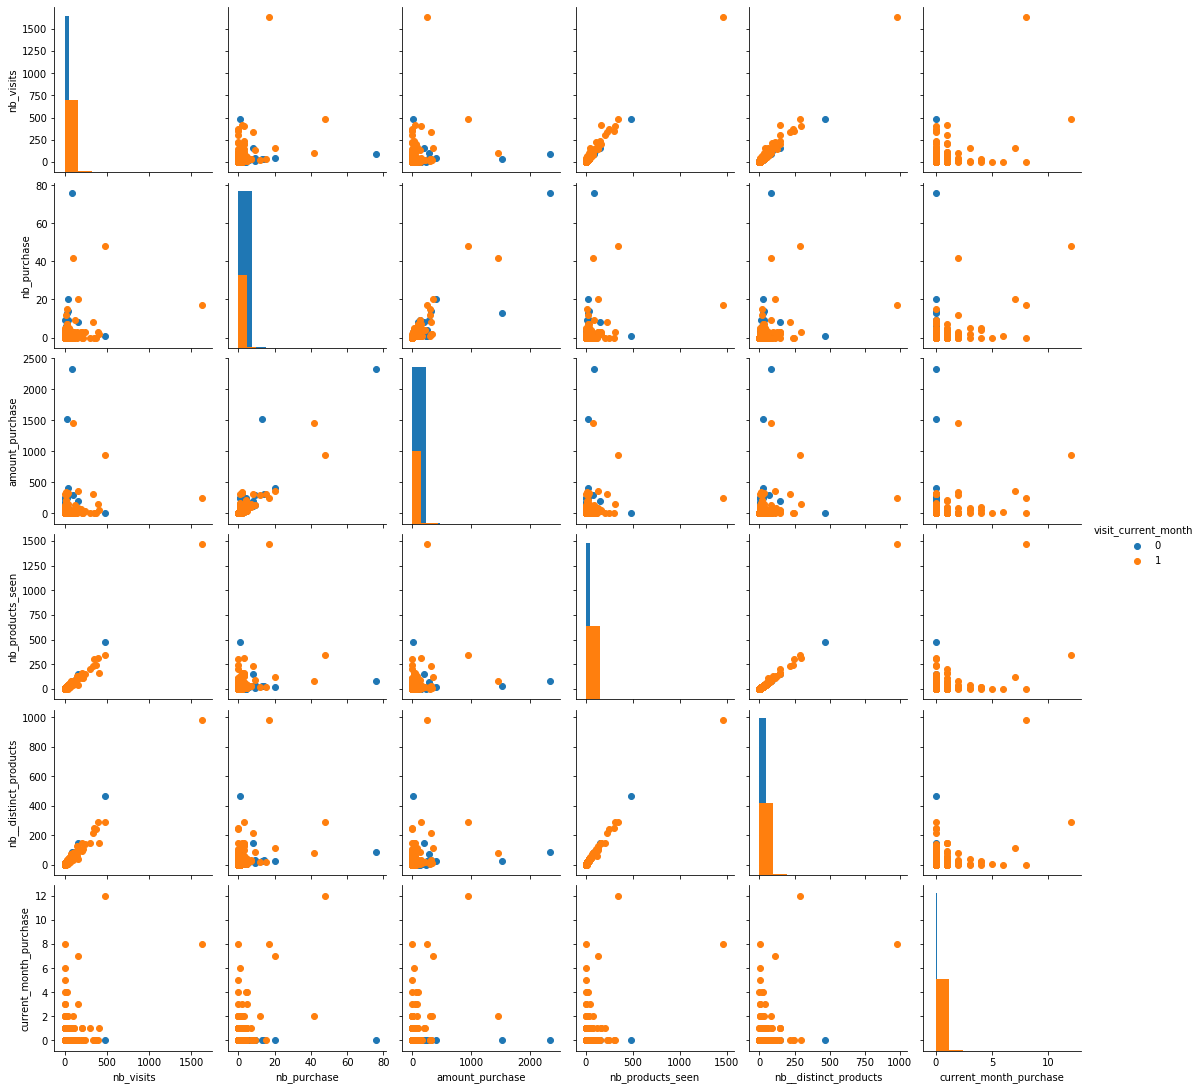

In [53]:
df_sample = pd.concat([df.iloc[:,1:6],df.iloc[:,-3:-1]], axis=1).sample(frac=0.05)
g = sns.PairGrid(df_sample, hue="visit_current_month")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

In [58]:
X = df.loc[:,~df.columns.isin(['user_id', 'visit_current_month','current_month_purchase','purchase_current_month'])]
y = df.loc[:, 'visit_current_month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#X_train['Y'] = y_train
#X_train = X_train.sample(frac=0.10, random_state=42)
#y_train = X_train['Y']
#X_train = X_train.drop('Y', axis=1)

X_train.head()

nb_visits  nb_purchase  amount_purchase  nb_products_seen  \
6363          26            0              0.0                25   
37351          1            0              0.0                 0   
2314           7            1             25.0                 7   
10112          5            0              0.0                 3   
32307          2            0              0.0                 2   

       nb__distinct_products  nb_distinct_category0  nb_distinct_category1  \
6363                      24                      8                     16   
37351                      0                      0                      0   
2314                       7                      5                      6   
10112                      3                      3                      3   
32307                      2                      2                      2   

       nb_distinct_category2  nb_distinct_product_purchased  \
6363                      16                              0   
37351                      0                              0   
2314                       6                              1   
10112                      3                              0   
32307                      2                              0   

       nb_distinct_category_purchased  ...  nb_distinct_category2_last_month  \
6363                                0  ...                                16   
37351                               0  ...                                 0   
2314                                1  ...                                 4   
10112                               0  ...                                 0   
32307                               0  ...                                 0   

       nb_distinct_product_purchased_last_month  \
6363                                          0   
37351                                         0   
2314                                          0   
10112                                         0   
32307                                         0   

       nb_distinct_category_purchased_last_month  nb_associated_months  \
6363                                           0                     6   
37351                                          0                     4   
2314                                           0                     7   
10112                                          0                     5   
32307                                          0                     0   

       nb_days_last_activity  nb_days_last_purchase  nb_active_months  \
6363                      51                  99999                 4   
37351                     43                    179                 2   
2314                      41                     84                 5   
10112                     93                    268                 2   
32307                     84                  99999                 1   

       nb_active_purchase_months  nb_purchase_total  amount_purchase_total  
6363                           0                  0                    0.0  
37351                          1                  3                   67.0  
2314                           2                  2                   27.0  
10112                          1                  1                   25.0  
32307                          0                  0                    0.0  

[5 rows x 27 columns]

In [29]:
#est = DecisionTreeClassifier(max_depth=1, class_weight = {0:1,1:10})
logistic_model = AdaBoostClassifier(random_state=42)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [20]:
Adaboost_model = AdaBoostClassifier(random_state=42)
param={'n_estimators':[10, 25 ,50, 100], 'learning_rate':[1,0.9,0.8,0.7]}
clf = GridSearchCV(Adaboost_model, cv=5,param_grid=param, n_jobs=-1, scoring ='recall')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [1, 0.9, 0.8, 0.7],
                         'n_estimators': [10, 25, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [31]:
clf.cv_results_
clf.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.5,
 'max_depth': 9,
 'n_estimators': 500}

In [22]:
y_pred = clf.predict(X_test)

In [125]:
pd.DataFrame(zip(X_train.columns,logistic_model.feature_importances_), columns = ['Features','Importance']).sort_values('Importance', ascending=False)

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [32]:
print(confusion_matrix(y_test,y_pred))

[[4482  593]
 [1006 1470]]


In [30]:
xgboost_model = xgb.XGBClassifier()
param = {'max_depth':[1,3,5,9],'learning_rate':[0.1,0.3,0.5],'colsample_bytree':[0.8],'n_estimators':[100,200, 500,1000]}
clf = GridSearchCV(xgboost_model, cv=5,param_grid=param, n_jobs=-1, scoring ='recall')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [33]:
print(accuracy_score(y_test,y_pred))

0.7882399682161303


In [101]:
df.to_csv(r'final_dataset.csv', header =True, index=False)

In [61]:
param ={'max_depth':9,'learning_rate':0.5,'colsample_bytree':0.8,'n_estimators':500}
xgboost_model = xgb.XGBClassifier(**param)
xgboost_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
y_pred = xgboost_model.predict(X_test)

In [64]:
confusion_matrix(y_test,y_pred)

array([[4482,  593],
       [1006, 1470]], dtype=int64)

In [65]:
xgboost_model.predict_proba(X_test)

array([[0.9973763 , 0.00262369],
       [0.8812957 , 0.11870429],
       [0.40381402, 0.596186  ],
       ...,
       [0.9907125 , 0.00928749],
       [0.20348734, 0.79651266],
       [0.996914  , 0.00308594]], dtype=float32)